### Initial Setup

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from termcolor import colored
import empyrical as emp
from utils import *
from sklearn.metrics import confusion_matrix

In [182]:
df = pd.read_csv('../HMM_randomportfolio.csv') # load of a portfolio composed by 30 random stocks by S&P500, computed in data.ipynb
df.pricingdate = df.pricingdate.astype('datetime64')
df = df.set_index(df.pricingdate).drop('pricingdate', axis=1)
#df['predicted'] = np.zeros(len(df.priceclose))
df

,priceclose,r1,signal
pricingdate,,,
2001-01-03,268.633857,0.012004,1
2001-01-04,266.142144,-0.009275,0
2001-01-05,253.156482,-0.048792,0
2001-01-08,245.341326,-0.030871,0
2001-01-09,247.053257,0.006978,1
...,...,...,...
2022-05-24,1871.590002,0.002630,1
2022-05-25,1913.690022,0.022494,1
2022-05-26,1923.819968,0.005293,1


### Walk-Forward Data Preparation

In [183]:
experiment = WalkForward(df, 'signal', step=1, start_interval = 400) # this function divides the dataset in thousands of different windows of length 400

### Initialization

First of all let's write down the  variables and functions we will need

In [ ]:
S = ['B','S'] # set of buy, sell states
n_visible = len(df.signal.unique())
n_hidden = len(S)

#### Forward-Backward Algorithm

In [ ]:
def forward(V, A, B, pi): #forward step
    T = V.shape[0]  # T is the length of the series
    N = A.shape[0] # N is the number of the states
    
    alpha = np.zeros((T,N))
    alpha[0] = pi[0] * B[:,V[0]]  
    for t in range(0,T-1): alpha[t+1] = np.array([alpha[t,:].dot(A[:,j]) * (B[j,V[t+1]]) for j in range(N)]) # formula to compute alpha
            
    return alpha

In [ ]:
def backward(V, A, B): # backward step
    T = V.shape[0]
    N = A.shape[0]
    
    beta = np.zeros((T,N))
    beta[T-1] = np.ones((N))
    for t in range(T-2, -1, -1): beta[t] = np.array([(beta[t+1,:] * B[:,V[t+1]]).dot(A[j,:]) for j in range(N)]) # formula to compute beta
            
    return beta

#### Viterbi Algorithm

In [ ]:
def viterbi(V,A,B,pi): # viterbi algorithm
    T = V.shape[0]
    N = A.shape[0]

    alpha = forward(V, A, B, pi)
    beta = backward(V, A, B)

    xi = np.zeros((T, N, N))
    for t in range(T-1):
        denominator = sum(alpha[t,:].dot(A[:,:]) * B[:,V[t+1]] * beta[t+1,:])
        for i in range(N):
            for j in range(N):
                numerator = alpha[t,i] * A[i,j] * (B[j,V[t+1]]) * beta[t+1,j]   
                xi[t,i,j] = numerator / denominator # formula to compute xi: we prefere to compute it in the viterbi step as we can easily calculate gamma

        
    gamma = np.zeros((T,N))
    for t in range(T): gamma[t] = np.array([sum(xi[t,i,:]) for i in range(N)]) # formula to compute gamma

    return gamma, xi

#### Baum-Welch Algorithm

In [ ]:
def baum_welch(V, A, B, pi, max_iter=100, epsilon=1e-5, verbose=True):
    T = V.shape[0]
    N = A.shape[0]
    
    # initialization: for the first iteration, our estimated parameters will be the initial ones
    A_bar = A
    B_bar = B
    pi_bar = pi
    
    for iteration in range(max_iter):
        gamma, xi = viterbi(V, A_bar, B_bar, pi_bar)

        # expectation-maximization step
        pi_bar = np.array([gamma[0,i] for i in range(N)])

        prev = [A_bar, B_bar, pi_bar]
               
        A_bar = np.zeros((N,N))
        for i in range(N): A_bar[i] = np.array([xi[:-1,i,j].sum() / gamma[:-1,i].sum() for j in range(N)])

        B_bar = np.zeros(B.shape)
        for j in range(B.shape[0]):
            for k in range(B.shape[1]):
                # we need to define a list of times t_bar where V[t] is equal to k
                t_bar = [0,0]
                for i in [0,1]: t_bar[i] = [t for t in range(T) if V[t]==k]
                B_bar[j,k] = sum([gamma[t,j] for t in t_bar[k]]) / gamma[:,j].sum()
        
        A_delta = delta(A_bar, prev[0])
        B_delta = delta(B_bar, prev[1])
        pi_delta = delta(pi_bar, prev[2])
        
        e = A_delta + B_delta + pi_delta
        
        if verbose: print(f'iteration {iteration} - delta {e}')
        if e < epsilon: break

    return {'A_hat': A_bar, 'B_hat': B_bar, 'pi_hat': pi_bar, 'gamma': gamma}

#### Initialization of the parameters

In [245]:
A_init = np.array([[.8,.2],
                  [.15,.85]])
B_init = np.array([[.8,.2],
                   [.2,.8]])
pi_init = np.array([0.95/2, 1.05/2])

### Analysis

Let's start by analyzing an the impact  that of the events of September 11th 2001 had on the trend market 

In [253]:
window = experiment[0]['universe_train']

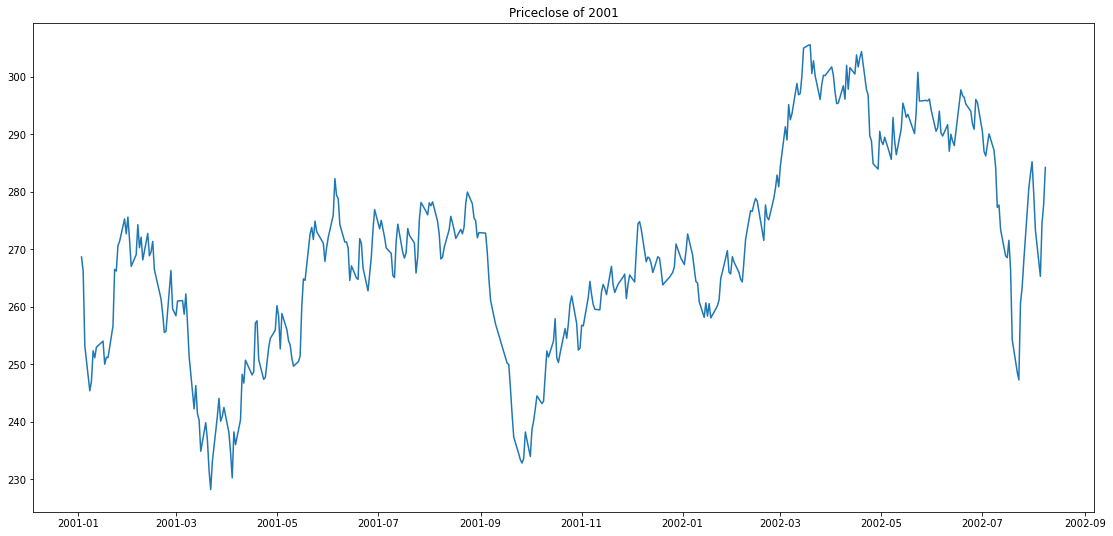

In [254]:
plt.figure(figsize = (19,9))
plt.plot(window.priceclose)
plt.title('Priceclose of 2001')
plt.savefig('../results/2001_priceclose.png')

In [247]:
est= baum_welch(window.signal, A_init, B_init, pi_init, max_iter=500, epsilon=1e-5, verbose=True)

iteration 0 - delta 0.019772332928305266
iteration 1 - delta 0.0046226365876525155
iteration 2 - delta 0.002064431685729182
iteration 3 - delta 0.0011013290795305504
iteration 4 - delta 0.0006578630305655448
iteration 5 - delta 0.0004250149307882545
iteration 6 - delta 0.0002908575823782463
iteration 7 - delta 0.00020802061174043652
iteration 8 - delta 0.00015405316878796426
iteration 9 - delta 0.00011735613306442172
iteration 10 - delta 9.15147784760017e-05
iteration 11 - delta 7.278041936056857e-05
iteration 12 - delta 5.886012499607012e-05
iteration 13 - delta 4.8296514671273346e-05
iteration 14 - delta 4.0132433549159296e-05
iteration 15 - delta 3.3721216543709055e-05
iteration 16 - delta 2.861504815520218e-05
iteration 17 - delta 2.44970017941507e-05
iteration 18 - delta 2.1138415594050825e-05
iteration 19 - delta 1.8371443471119738e-05
iteration 20 - delta 1.6070957510275766e-05
iteration 21 - delta 1.4142361088252405e-05
iteration 22 - delta 1.2513224310062698e-05
iteration 23 -

As we can see the algorithm converged in 17 iterations. Let's explore the results

In [248]:
# estimated transition matrix
pd.DataFrame(est['A_hat'], index=['Sell','Buy'], columns=['Sell','Buy'])

,Sell,Buy
Sell,0.721491,0.278509
Buy,0.251287,0.748713


In [255]:
# estimated emission probabilities
pd.DataFrame(est['B_hat'], index=['Sell','Buy'], columns=['Negative Daily Return','Positive Daily Return'])

,Negative Daily Return,Positive Daily Return
Sell,0.631735,0.368265
Buy,0.438250,0.561750


In [256]:
# estimated initial probabilities
pd.DataFrame(est['pi_hat'], index=['Sell','Buy'], columns=['Pr'])

,Pr
Sell,0.458754
Buy,0.541246


In [257]:
state= np.ones(len(est['gamma']))
for t in range(len(est['gamma'])): state[t] = np.argmax(est['gamma'][t])
experiment[0]['state'] = state

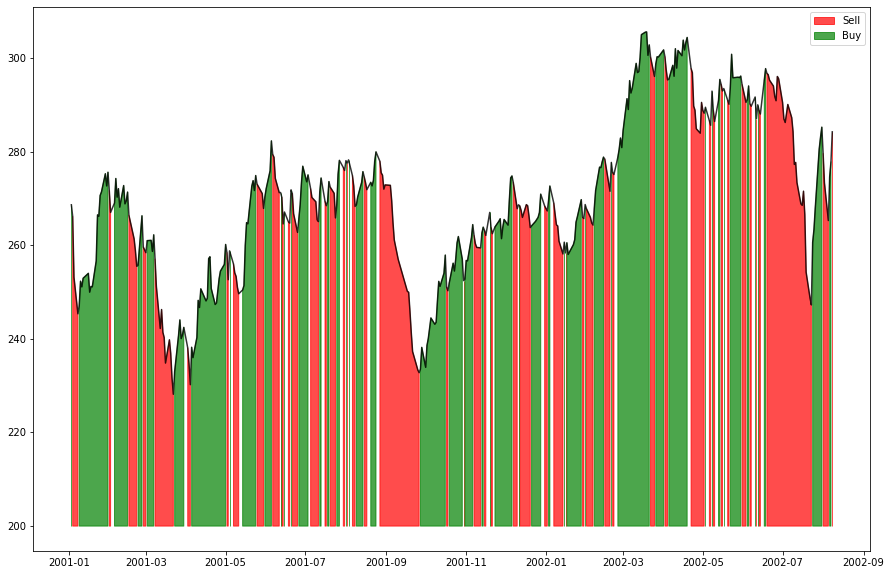

In [258]:
plt.figure(figsize=(15,10))
plt.plot(window.priceclose, color='black',alpha=.8)
plt.fill_between(window.index, window.priceclose,200,where=experiment[0]['state']==0, color='red', alpha=.7, label='Sell')
plt.fill_between(window.index, window.priceclose,200,where=experiment[0]['state']==1, color='green', alpha=.7, label = 'Buy')
plt.savefig('../results/2001_states.png')
plt.legend()

The model fitted the series with great accuracy. It has been able to detect increasing and decreasing periods with very few mistakes

Now let's analyze, for istance, the period of the 2008 crisis

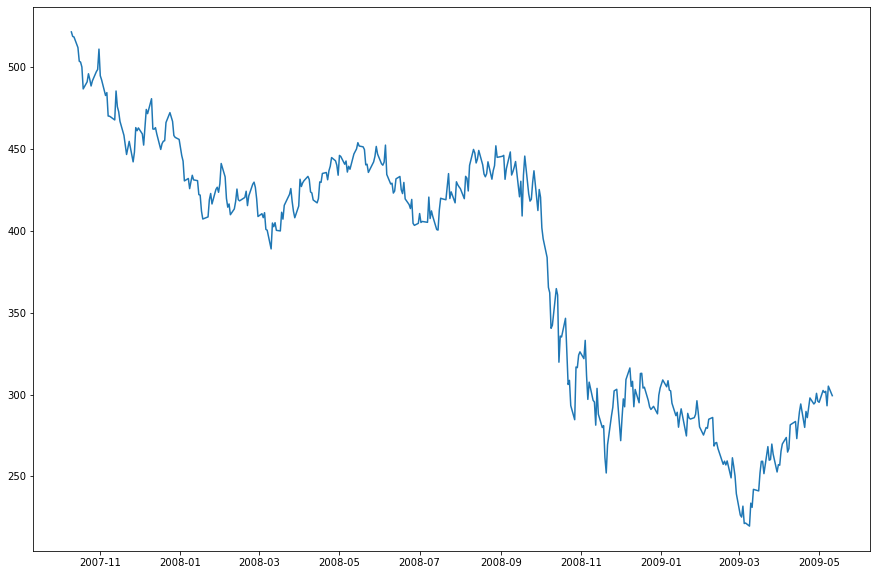

In [260]:
window = experiment[1700]['universe_train']
plt.figure(figsize=(15,10))
plt.plot(window.priceclose)

This period is characterized by an high volatility and a lot of uncertainty, until the crash of the market in October 2008

In [281]:
est= baum_welch(window.signal, A_init, B_init, pi_init, max_iter=500, epsilon=1e-4, verbose=False)

In [282]:
# estimated transition matrix
pd.DataFrame(est['A_hat'], index=['Sell','Buy'], columns=['Sell','Buy'])

,Sell,Buy
Sell,0.725365,0.274635
Buy,0.231705,0.768295


In [283]:
# estimated emission probabilities
pd.DataFrame(est['B_hat'], index=['Sell','Buy'], columns=['Negative Daily Return','Positive Daily Return'])

,Negative Daily Return,Positive Daily Return
Sell,0.569244,0.430756
Buy,0.487830,0.512170


The uncertainty of the period affects very much the emission probabilities matrix. In fact, we can see that all probabilities are near 0.5, while before they were more distant

In [284]:
# estimated initial probabilities
pd.DataFrame(est['pi_hat'], index=['Sell','Buy'], columns=['Pr'])

,Pr
Sell,0.583502
Buy,0.416498


In [289]:
state= np.ones(len(est['gamma']))
for t in range(len(est['gamma'])): state[t] = np.argmax(est['gamma'][t])
experiment[1700]['state'] = state

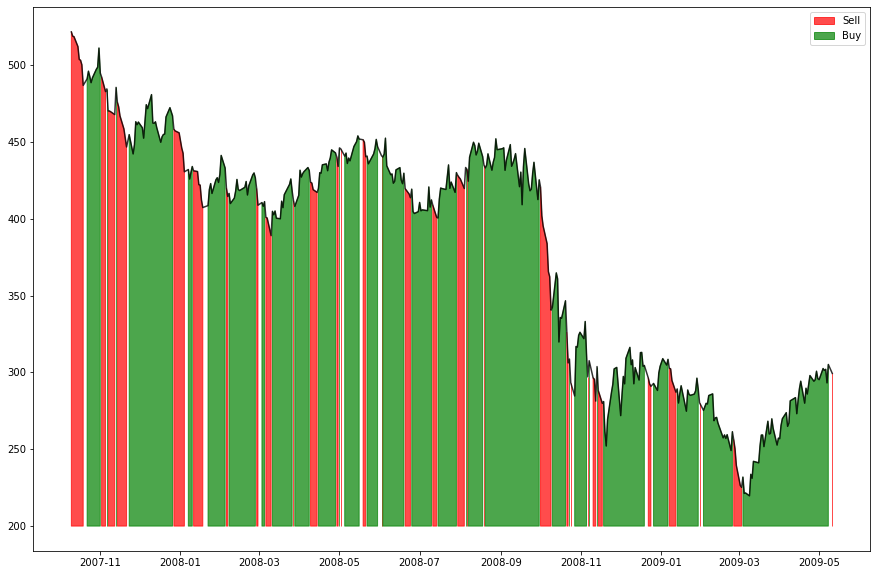

In [290]:
plt.figure(figsize=(15,10))
plt.plot(window.priceclose, color='black',alpha=.8)
plt.fill_between(window.index, window.priceclose,200,where=experiment[1700]['state']==0, color='red', alpha=.7, label='Sell')
plt.fill_between(window.index, window.priceclose,200,where=experiment[1700]['state']==1, color='green', alpha=.7, label = 'Buy')
plt.savefig('../results/2008_states.png')
plt.legend()

Given the fact that this period is uncertain, unless this prediction seems to be good, we may want more accurate result. This is a good reason to explore the meaning of local optimization and see the effect of changing initialization. In fact, if we set the initial A to:

In [294]:
A_init = np.array([[.5,.5],[.5,.5]])

and run again the code

In [295]:
est= baum_welch(window.signal, A_init, B_init, pi_init, max_iter=500, epsilon=1e-4, verbose=False)

we now obtain as estimation of A

In [296]:
pd.DataFrame(est['A_hat'], index=['Sell','Buy'], columns=['Sell','Buy'])

,Sell,Buy
Sell,0.426762,0.573238
Buy,0.605466,0.394534


that is a kind of strange result, considering now that the probability of moving from one trend to another is higher that remaining in the same one

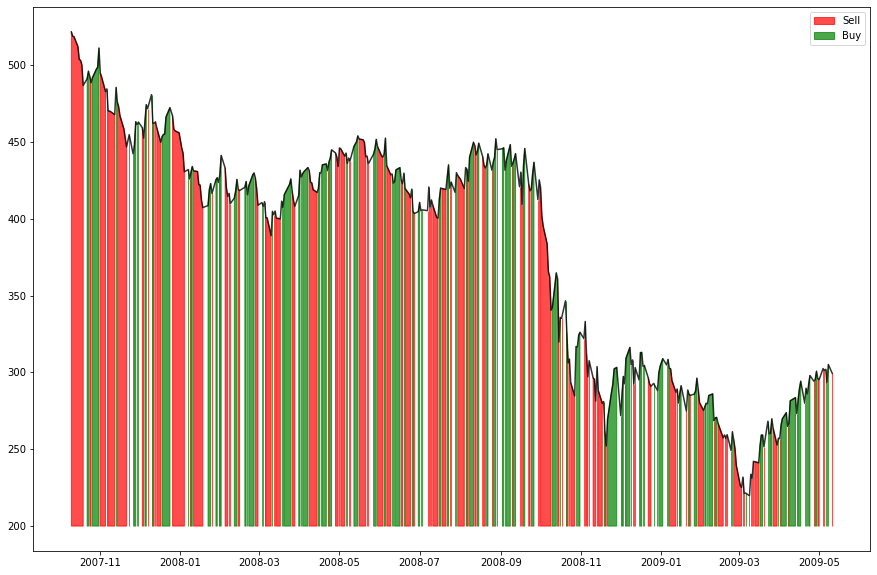

In [298]:
state= np.ones(len(est['gamma']))
for t in range(len(est['gamma'])): state[t] = np.argmax(est['gamma'][t])
experiment[1700]['state'] = state
plt.figure(figsize=(15,10))
plt.plot(window.priceclose, color='black',alpha=.8)
plt.fill_between(window.index, window.priceclose,200,where=experiment[1700]['state']==0, color='red', alpha=.7, label='Sell')
plt.fill_between(window.index, window.priceclose,200,where=experiment[1700]['state']==1, color='green', alpha=.7, label = 'Buy')
plt.savefig('../results/2008_states.png')
plt.legend()

And now, in fact, we still obtain a pretty accurate trend detection, but it is way more sensitive to small changes and trend windows are smaller. It could be interesting the analysis of the probability distribution of the daily returns:

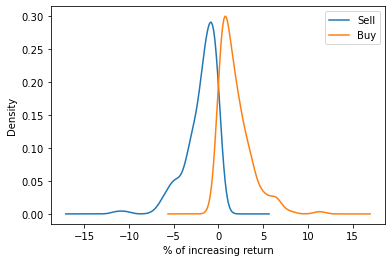

In [299]:
 # conditional distribution of r1 given the state
(window.r1[experiment[1700]['state']==0]*100).plot.density()
(window.r1[experiment[1700]['state']==1]*100).plot.density()
plt.legend(['Sell','Buy'])
plt.xlabel('% of increasing return')
plt.savefig('../results/2008_signal_distribution.png')

### Walk-Forward Forecasting

In [ ]:
#walk forward: for each window, a forward step is computed to forecast the next state
predictions = []
for exp in range(len(experiment)):
    train = baum_welch(experiment[exp]['train_input'], A_init, B_init, pi_init, max_iter=100, epsilon=1e-19, verbose = 0)
    prediction = train['gamma'][-2].dot(train['A_hat']).argmax()
    print('experiment n.', exp, 'and his state prediction is:', prediction)
    predictions.append(prediction)

In [19]:
pd.Series(predictions).value_counts()

1    4093
0     893
dtype: int64

In [21]:
hh = pd.concat([df.reset_index(), pd.Series(predictions)], axis = 1).dropna().rename(columns={0:'prediction_state'})

In [22]:
hh.pricingdate = pd.to_datetime(hh.pricingdate)
hh = hh.set_index('pricingdate')

Return: 9.48
Volatility: 19.45
Sharpe Ratio: 0.56
Sortino Ratio: 0.8
Calmar Ratio: 0.22
Max Draw-Down: -43.97 Start: 09/14/2007 End: 03/05/2009
Return: 8.24
Volatility: 21.66
Sharpe Ratio: 0.47
Sortino Ratio: 0.67
Calmar Ratio: 0.17
Max Draw-Down: -49.51 Start: 03/13/2001 End: 08/07/2002
Return: 9.74
Volatility: 21.66
Sharpe Ratio: 0.54
Sortino Ratio: 0.77
Calmar Ratio: 0.16
Max Draw-Down: -59.11 Start: 02/20/2007 End: 03/09/2009


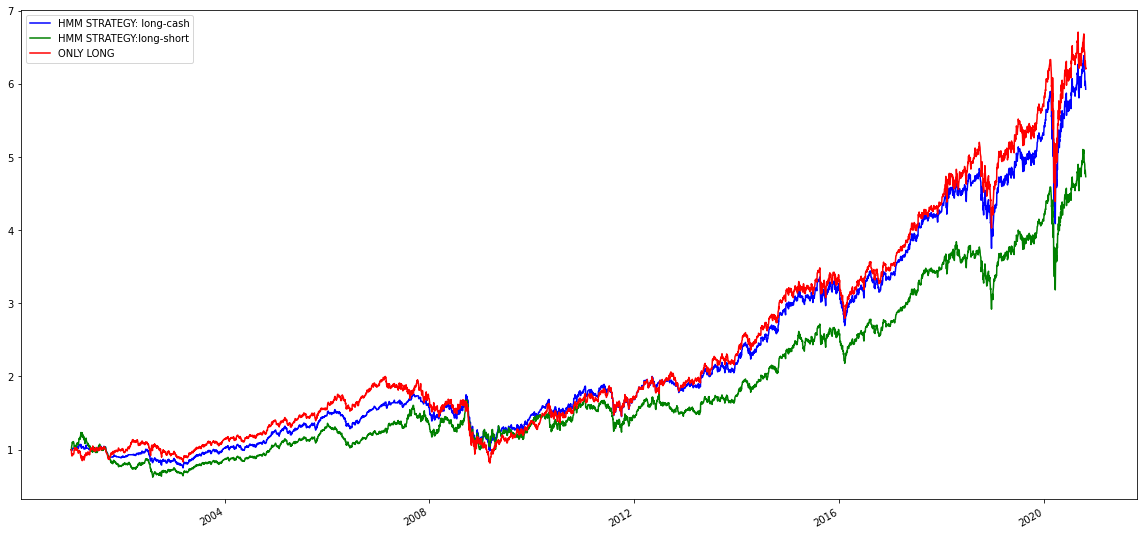

In [109]:
# plotting of the results of performance_extd function: see utils.py for further information

performance_extd(hh.prediction_state.shift(-1)*hh.r1, color = 'blue', label = 'HMM STRATEGY: long-cash')
performance_extd(hh.prediction_state.replace(0, -1).shift(-1)*hh.r1, color = 'green', label = 'HMM STRATEGY: long-short')
performance_extd(hh.r1, label = 'ONLY LONG')
plt.legend()
plt.savefig('../results/CAGR_strategy.png')

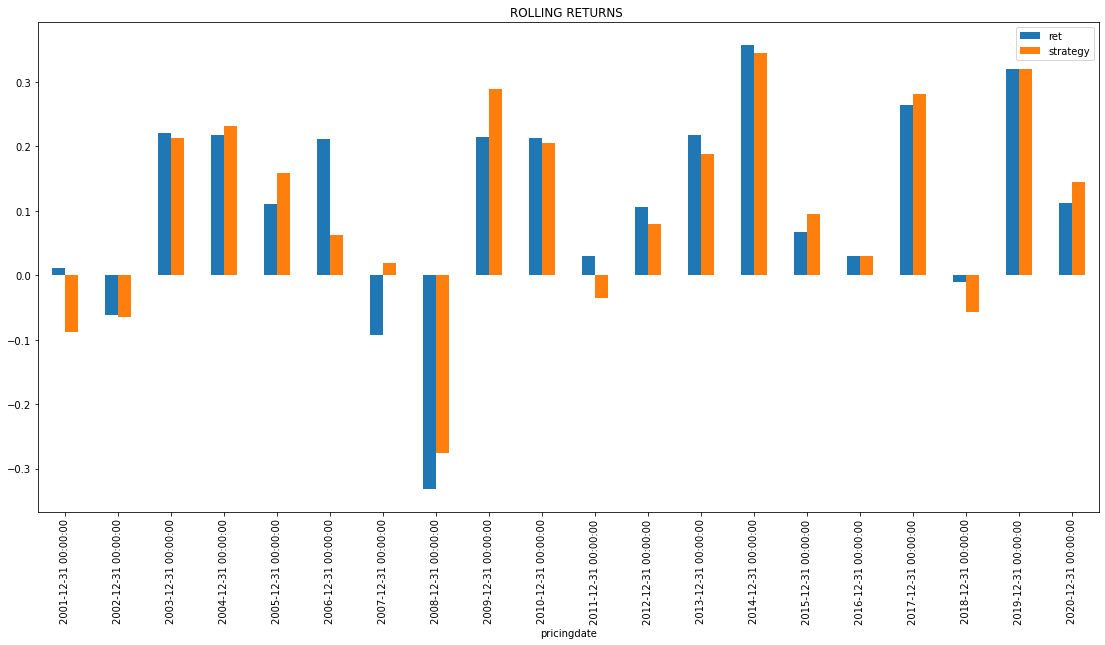

In [71]:
# plotting of the rolling bars

hh['ret'] = hh.r1 
hh['long-cash']= hh.prediction_state.shift(-1)*hh.r1
hh['long-short'] = hh.prediction_state.replace(0, -1).shift(-1)*hh.r1
hh[['ret', 'long-cash', 'long-short']].groupby(pd.Grouper(freq = 'Y')).apply(lambda x: emp.annual_return(x, annualization = 252)).plot(figsize = (19,9), kind = 'bar', color = ['red', 'blue', 'green'])
plt.title('ROLLING RETURNS ')
plt.savefig('../results/rollingbars_strategy.png')

In [64]:
hh.to_csv('../results/result_HMM_randomportfolio1.csv')